# Datenabfrage von Scopus

Die Python-Bibliothek [pybliometrics](https://pybliometrics.readthedocs.io/en/stable/index.html) wird genutzt.

In [118]:
import pybliometrics
import pandas as pd
from datetime import datetime

import squarify
import matplotlib.pyplot as plt

from pybliometrics.scopus import ScopusSearch

pybliometrics.scopus.init()  # read API keys

import squarify
import matplotlib.pyplot as plt

In [119]:
import jupyter_black

jupyter_black.load()

In [120]:
%load_ext watermark
%watermark -v --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.2
IPython version      : 8.5.0

jupyter_black: 0.4.0
pandas       : 1.5.3
squarify     : 0.4.4
matplotlib   : 3.6.3
pybliometrics: 4.1



## Datenabfrage für ALD

Zu erst werden die Daten für ALD anhand des Begriffes ALD abgefragt. Es soll untersucht werden, ob sich Kernjournale definieren lassen, welche für die Untersuchung zur Informationsabdeckung genutzt werden können.


In [ ]:
# Datenabfrage für ALD (ca. 15 Min.)
query_ALD = 'TITLE-ABS-Key("atomic layer deposition")'
search_ALD = ScopusSearch(query_ALD, verbose=True, download=True)

#print(search_ALD.get_results_size())
#print(search_ALD.results[0])

In [107]:
# Daten in DataFrame umwandeln für weitere Datenanalyse
search_ALD_df = pd.DataFrame([doc._asdict() for doc in search_ALD.results])
# Betrachtung der Journaltitel für Journalartikel
search_ALD_df = search_ALD_df[search_ALD_df["subtypeDescription"] == "Article"]
journal_counts = search_ALD_df["publicationName"].value_counts()
# journal_counts = journal_counts[journal_counts.values > journal_counts.median()]
# journal_counts.mean()

In [128]:
journal_counts.shape[0]

1184

In [108]:
journal_counts.head(25)

Journal of Vacuum Science and Technology A Vacuum Surfaces and Films    927
Applied Physics Letters                                                 882
ACS Applied Materials and Interfaces                                    820
Applied Surface Science                                                 625
Chemistry of Materials                                                  524
Thin Solid Films                                                        453
Journal of Physical Chemistry C                                         444
Journal of Applied Physics                                              426
Nanotechnology                                                          353
Journal of the Electrochemical Society                                  352
IEEE Electron Device Letters                                            287
IEEE Transactions on Electron Devices                                   266
Rsc Advances                                                            194
Journal of M

In [114]:
print(
    f"Diese 25 Journale beinhalten {sum(journal_counts.head(25).values) / sum(journal_counts.values) * 100:.2f} % aller gefundenen Journalartikel."
)

Diese 25 Journale beinhalten 43.76 % aller gefundenen Journalartikel.


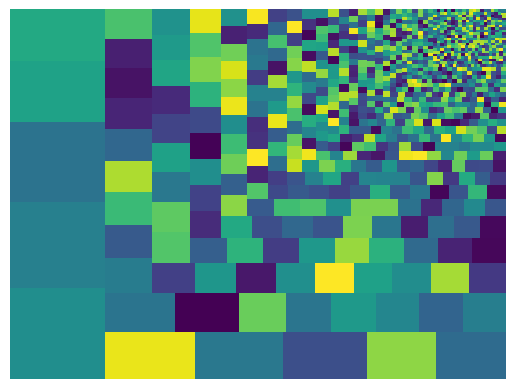

In [131]:
# Plot treemap
norms = squarify.normalize_sizes(journal_counts.values.tolist(), dx=3, dy=3)
squarify.plot(sizes=norms, alpha=1, pad=False)
plt.axis("off")

plt.savefig(
    "figures/plot_treemap_journale_ALD_scopus.png", bbox_inches="tight", dpi=300
)
plt.show()

Es zeigt sich, dass es keine definierten Kernjournale gibt. Dies ist für das interdisziplinäre Forschungsfeld der ALD nicht überraschend.

Für die Bewertung der Informationsabdeckung wird daher ein dokumentenbasierter Ansatz gewählt. Zur Suche werden keywords verwendet.

Für die Datenabfrage für ALD wird iterativ vorgegangen. Zuerst wird nur nach dem Begriff "atomic layer deposition" gesucht. Anhand dieser Daten kann nun eine Optimierung der genutzen Keywords für die Suche vorgenommen werden.

In [ ]:
# Datenabfrage für ALD, Zeitscheibe 2020 - 2023
query = 'TITLE-ABS-Key("atomic layer deposition") AND PUBYEAR > 2019 AND PUBYEAR < 2024'
search = ScopusSearch(query, verbose=True, download=True)

print(search.get_results_size())
print(search.results[0])


In [ ]:
# Daten in DataFrame umwandeln für weitere Datenanalyse
search_df = pd.DataFrame([doc._asdict() for doc in search.results])
print(search_df.head())


In [25]:
search_df.columns

Index(['eid', 'doi', 'pii', 'pubmed_id', 'title', 'subtype',
       'subtypeDescription', 'creator', 'afid', 'affilname',
       'affiliation_city', 'affiliation_country', 'author_count',
       'author_names', 'author_ids', 'author_afids', 'coverDate',
       'coverDisplayDate', 'publicationName', 'issn', 'source_id', 'eIssn',
       'aggregationType', 'volume', 'issueIdentifier', 'article_number',
       'pageRange', 'description', 'authkeywords', 'citedby_count',
       'openaccess', 'freetoread', 'freetoreadLabel', 'fund_acr', 'fund_no',
       'fund_sponsor'],
      dtype='object')

### Publikationsarten


In [26]:
# Publikationsarten
search_df["subtypeDescription"].value_counts()

Article              5442
Conference Paper      584
Review                286
Book Chapter           85
Erratum                25
Conference Review      18
Book                    7
Note                    5
Editorial               4
Letter                  4
Short Survey            3
Retracted               1
Data Paper              1
Name: subtypeDescription, dtype: int64

In [ ]:
# conference paper
search_df_conf_pap = search_df[search_df["subtypeDescription"] == "Conference Paper"]
search_df_conf_pap[['eid', 'doi','title', 'subtype','creator', 'author_names', 'coverDate', 'publicationName', 'article_number']]

In [ ]:
# conference review
search_df_conf_rev = search_df[search_df["subtypeDescription"] == "Conference Review"]
search_df_conf_rev[['eid', 'title', 'subtype', 'subtypeDescription','coverDate', 'publicationName', 'article_number']]

In [ ]:
# book chapter
search_df_book_chapter = search_df[search_df["subtypeDescription"] == "Book Chapter"]
search_df_book_chapter[['eid', 'doi','title', 'subtype','creator', 'author_names', 'coverDate', 'publicationName', 'article_number']]

In [ ]:
# Erratum
search_df[search_df["subtypeDescription"] == "Erratum"]

In [32]:
# Eingrenzung auf Article (ar) und Review (re), wo ein peer review process anzunehmen ist
# zusätzlich werden Erratum (er) und Retracted (tb) berücksichtigt
search_df_reduced = search_df[search_df["subtype"].isin(['ar','re','er','tb'])]
search_df_reduced.shape

(5754, 36)

In [33]:
# No DOI
search_df_reduced_nodoi = search_df_reduced[search_df_reduced["doi"].isnull()]
search_df_reduced_nodoi.shape


(14, 36)

In [34]:
# search_df_reduced["doi"].str.startswith("1").value_counts() # 5740 von 5754

search_df_reduced_nodoi["subtypeDescription"].value_counts()

Article    14
Name: subtypeDescription, dtype: int64

In [35]:
# No Abstract
search_df_reduced[search_df_reduced["description"].isnull()].shape


(2, 36)

In [36]:
# No abtract AND no keywords
search_df_reduced[search_df_reduced["description"].isnull() & search_df_reduced["authkeywords"].isnull()]

,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,affilname,...,pageRange,description,authkeywords,citedby_count,openaccess,freetoread,freetoreadLabel,fund_acr,fund_no,fund_sponsor


In [37]:
# no keywords
search_df_reduced[search_df_reduced["authkeywords"].isnull()].shape

(1746, 36)

### Analyse Keywords

Mithilfe der Keywords wird geschaut, welche der Keywords zur Optimierung des Suchstrings genutzt werden können.
Scopus nutzt die von AutorInnen vergebenen Keywords als `authkeywords`.

In [ ]:
keywords = search_df_reduced["authkeywords"]
print(keywords)
print(keywords.isnull().value_counts())

In [ ]:
# multiple keywords are separate via | 
# https://pandas.pydata.org/pandas-docs/stable/whatsnew/v0.25.0.html#series-explode-to-split-list-like-values-to-rows

keywords_split = keywords.str.split(pat='|').explode("authkeywords")
keywords_splitted = keywords_split.str.split(pat='(').explode("authkeywords")
# remove spaces
keywords_splitted = keywords_splitted.str.strip()

# remove trailing )
for row, keyword in enumerate(keywords_splitted):
    if keyword: # could be none
        if keyword.endswith(")"):
            keywords_splitted[row] = keyword[:-1]
            
# transform to lower case
keywords_splitted = keywords_splitted.str.lower()
print(keywords_splitted)


In [ ]:
# count occurence of keywords and sort by occurence
print(len(keywords_splitted.value_counts(sort=True)))
keywords_splitted.value_counts(sort=True).head(25)

In [41]:
# query = 'TITLE-ABS-Key("atomic layer deposition") AND PUBYEAR > 2019 AND PUBYEAR < 2025'
query2 = 'TITLE-ABS-Key("atomic layer deposition" OR "Atomic layer deposition") AND PUBYEAR > 2019 AND PUBYEAR < 2024'
search2 = ScopusSearch(query2, verbose=True, download=False)

search2.get_results_size()

6467

Groß- und Kleinschreibung hat keinen Einfluss.

In [42]:
query4 = 'TITLE-ABS-Key("atomic layer deposition" AND "thin film*") AND PUBYEAR > 2019 AND PUBYEAR < 2024'
search4 = ScopusSearch(query4, verbose=True, download=False)

print(search4.get_results_size())

2237


Die mit ALD erzeugten dünnen Schichten werden häufig durch das Keyword "thin films" oder "thin film" beschrieben. Eine Eingrenzung der Suche auf "thin film*" liefert jedoch deutlich weniger Suchergebnisse. Stattdessen können diese beiden Suchansätzen mittels OR verknüpft werden.

In [43]:
query5 = 'TITLE-ABS-Key("atomic layer deposition" OR ("ALD" AND "thin film*")) AND PUBYEAR > 2019 AND PUBYEAR < 2024'
search5 = ScopusSearch(query5, verbose=True, download=False)

print(search5.get_results_size())

6506


In [ ]:
query6 = 'TITLE-ABS-KEY ( ( "ALD" AND "thin film*" ) AND NOT "atomic layer deposition") AND PUBYEAR > 2019 AND PUBYEAR < 2024'
search6 = ScopusSearch(query6, verbose=True, download=True)

print(search6.get_results_size())
search_diff = pd.DataFrame([doc._asdict() for doc in search6.results])

# only consider articles and reviews
search_diff_reduced = search_diff[search_diff["subtype"].isin(['ar','re','er','tb'])]

df = search_diff_reduced[["title"]]
pd.options.display.max_colwidth = 200
print(df)

Ein Ergebnis beschäftigt sich, laut Titel, mit Ratten. Das ist für ALD eher ungewöhnlich. Eine genaue Analyse der Quelle zeigt, das ALD auch für "alcohol-related liver disease" stehen kann. Dies ist in der Suche auszuschließen.

In [45]:
query7 = 'TITLE-ABS-Key("atomic layer deposition" OR ("ALD" AND "thin film*" AND NOT ("alcohol-related liver disease"))) AND PUBYEAR > 2019 AND PUBYEAR < 2024'
search7 = ScopusSearch(query7, verbose=True, download=False)

print(search7.get_results_size())

6505


In [47]:
# Einträe de auch in en enthalten? -> ja
query_en_de = 'TITLE-ABS-Key("atomic layer deposition" OR "Atomlagenabscheidung") AND PUBYEAR > 2019 AND PUBYEAR < 2025'
search_all_en_de = ScopusSearch(query_en_de, download=False)
search_all_en_de.get_results_size()

8030

## Zeitscheibe 2010 - 2013

Es werden zwei Zeitscheiben betrachtet. Die obige Anlayse bezieht sich nur auf die Suchergebnisse für 2020 - 2023. Es wird vermutet, dass der obige Suchstring für beide Zeitscheiben gut funktioniert. Dies wird für 2010 - 2013 hier überprüft.

In [ ]:
# Datenabfrage für ALD, Zeitscheibe 2010 - 2013
query2010 = 'TITLE-ABS-Key("atomic layer deposition") AND PUBYEAR > 2009 AND PUBYEAR < 2014'
search2010 = ScopusSearch(query2010, verbose=True, download=True)

print(search2010.get_results_size())
print(search2010.results[0])

In [49]:
# Daten in DataFrame umwandeln für weitere Datenanalyse
search2010_df = pd.DataFrame([doc._asdict() for doc in search2010.results])

In [50]:
# Publikationsarten
search2010_df["subtypeDescription"].value_counts()

Article              2670
Conference Paper     1185
Review                 57
Conference Review      52
Book Chapter           50
Erratum                10
Letter                  8
Short Survey            2
Editorial               2
Book                    2
Name: subtypeDescription, dtype: int64

In [ ]:
# Eingrenzung auf Article (ar) und Review (re), wo ein peer review process anzunehmen ist
# zusätzlich werden Erratum (er) und Retracted (tb) berücksichtigt
search_df_reduced_2010 = search2010_df[search2010_df["subtype"].isin(['ar','re','er','tb'])]
search_df_reduced_2010.shape

In [ ]:
# keyword für alle Daten
pd.options.mode.chained_assignment = None  # default='warn'
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

keywords = search2010_df["authkeywords"]
# split 
keywords_split = keywords.str.split(pat='|').explode("authkeywords")
keywords_splitted = keywords_split.str.split(pat='(').explode("authkeywords")

# remove spaces
keywords_splitted = keywords_splitted.str.strip()

# remove trailing )
for row, keyword in enumerate(keywords_splitted):
    if keyword: # could be none
        if keyword.endswith(")"):
            keywords_splitted[row] = keyword[:-1]

# transform to lower case
keywords_splitted = keywords_splitted.str.lower()

print(len(keywords_splitted.value_counts(sort=True)))
keywords_splitted.value_counts(sort=True).head(25)

In [ ]:
# keyword für begrenzten Typen
pd.options.mode.chained_assignment = None  # default='warn'
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

keywords = search_df_reduced_2010["authkeywords"]
# split 
keywords_split = keywords.str.split(pat='|').explode("authkeywords")
keywords_splitted = keywords_split.str.split(pat='(').explode("authkeywords")

# remove spaces
keywords_splitted = keywords_splitted.str.strip()

# remove trailing )
for row, keyword in enumerate(keywords_splitted):
    if keyword: # could be none
        if keyword.endswith(")"):
            keywords_splitted[row] = keyword[:-1]

# transform to lower case
keywords_splitted = keywords_splitted.str.lower()

print(len(keywords_splitted.value_counts(sort=True)))
keywords_splitted.value_counts(sort=True).head(25)

In [ ]:
# Such Prüfung wird die Differenz der per OR verkünpften Suchstrings betrachtet
query2010_2 = 'TITLE-ABS-KEY ( ( "ALD" AND "thin film*" ) AND NOT "atomic layer deposition" ) AND PUBYEAR > 2009 AND PUBYEAR < 2014'
search2010_2 = ScopusSearch(query2010_2, verbose=True, download=True)

print(search2010_2.get_results_size())
search_diff_2010 = pd.DataFrame([doc._asdict() for doc in search2010_2.results])

df = search_diff_2010[["doi","title"]]
pd.options.display.max_colwidth = 100
print(df)

In [ ]:
# Suche nur nach ALD
query_ALD = 'TITLE-ABS-KEY ("ALD" AND NOT "atomic layer deposition") AND PUBYEAR > 2009 AND PUBYEAR < 2014'
search_ALD = ScopusSearch(query_ALD, verbose=True, download=True)

search_ALD.get_results_size()
search_diff_ALD = pd.DataFrame([doc._asdict() for doc in search_ALD.results])


df = search_diff_ALD[["doi","title"]]
pd.options.display.max_colwidth = 100
# df.to_csv("data_only_ALD.csv")
print(df)